# Convolutions in action

In [1]:
import torch

In [ ]:
test1

In [113]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import datetime
import collections
import numpy as np

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                            (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                            (0.2470, 0.2435, 0.2616))
    ]))
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


Here we have 3 input features per pixel (the RGB channels) and an arbitrary number of channels in the output (16). We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we’ll get, even after training, will turn out to be useless.2 Let’s stick to a kernel size of 3 × 3. A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image.

In our case, both the kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particu- larly meaningful. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a Batches × Channels × Height × Width shaped tensor as input.

In [36]:
conv = nn.Conv2d(3, 16, kernel_size=3)
print('Shape of kernel weights and bias')
print(conv.weight.shape, conv.bias.shape)
print('')
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
print('Shape of input and output')
print(img.unsqueeze(0).shape, output.shape)

Shape of kernel weights and bias
torch.Size([16, 3, 3, 3]) torch.Size([16])

Shape of input and output
torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


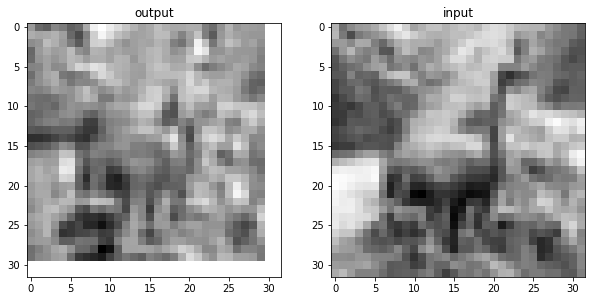

In [37]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

#### Kernel 1
Each pixel in the output gets the mean of its neighbor (3x3)

torch.Size([1, 3, 32, 32]) torch.Size([1, 1, 32, 32])
Output after appplying the Kernel that averages based on neighborhood pixels


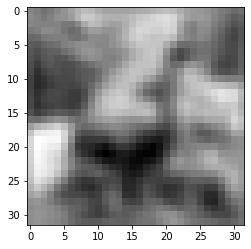

In [38]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape, output.shape)
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
    
print('Output after appplying the Kernel that averages based on neighborhood pixels')
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

#### Kernel 2
convolution kernel enhances the vertical edges. When an edge is "detected" that means that the output has a high magnitude.

In [39]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

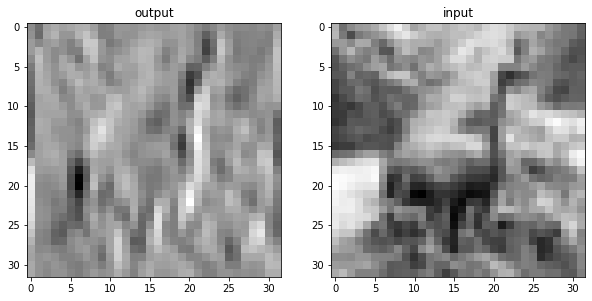

In [40]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.show()

#### Downsampling technique example
Downsample our image by half by using the max pooling technique, we’ll want to use a size of 2.

In [41]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### NN structure
1. The 1st convolution takes us from 3 RGB channels to 16. These 16 independent features are being used to discriminate low-level features of birds and airplanes
2. The tanh activation function and yield a resulting 16-channel 32x32 image
3. Applying MaxPool2d(2) module shrinks the output to a 16-channel 16x16 image.
4. The image is convolved and yields an 8 channel 16 x 16 output which will consist of higher level features
5. The tanh activation function and yield a resulting 8-channel 16x16 image
6. Applying MaxPool2d(2) module shrinks the output to a 8-channel 8x8 image

In [42]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #1
            nn.Tanh(), #2
            nn.MaxPool2d(2), #3
            nn.Conv2d(16, 8, kernel_size=3, padding=1), #4
            nn.Tanh(), #5
            nn.MaxPool2d(2),#6
            # ... <1> ERROR
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [43]:
numel_list = [p.numel() for p in model.parameters()]
print('Total number of parameters:' + '\n' + str(sum(numel_list)))
print('Number of parameters per layer:' + '\n' + str(numel_list))

Total number of parameters:
18090
Number of parameters per layer:
[432, 16, 1152, 8, 16384, 32, 64, 2]


### Writing our network as a nn.Module

A forward function is defined here, that takes the inputs to the module and returns the output. This is where we define our module’s computation. Writing the forward function explicitly allows us to manipulate the outputs between layers. 

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) 
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        
        #This reshape is what we were missing earlier
        out = out.view(-1, 8 * 8 * 8)
        
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [45]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

#### Benefits of using functional counterpart for every nn module
Functional essentially means having no internal state. Submodules such as nn.Tanh and nn.MaxPool2d do not have parameters and their output value is solely and fully determined by the value input arguments. 

torch.nn.functional takes inputs and parameters as arguments to the function call, instead of working on the input arguments and stored parameters (like its module counterparts)

In [46]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1049, 0.0675]], grad_fn=<AddmmBackward0>)

### Training
<strong>Function breakdown:</strong>
1. Looping over the epochs numbered from 1 to n_epochs. The training loop function takes the number of epocs as an input.
2. Loops over the dataset in the batches which were created by the data loader 
3. Fits a batch of our model
4. Computes the loss which we try to minimize
5. Getting rid of the gradients from the last iteration in the loop
6. Performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
7. Updates the model
8. Sums the losses we saw over the epoch. The loss is transformed to a Python number with .item(), to escape the gradients.
9. Divides by the length of the training data loader to get the average loss per batch. This is a much more intuitive measure than the sum.

In [48]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <1>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <2>
            
            outputs = model(imgs)  # <3>
            
            loss = loss_fn(outputs, labels)  # <4>

            optimizer.zero_grad()  # <5>
            
            loss.backward()  # <6>
            
            optimizer.step()  # <7>

            loss_train += loss.item()  # <8>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <9>

<strong>Arguments breakdown:</strong>
1. <strong>n_epochs</strong> <br>
Number of epochs which we wish to train the model. Looping over the epochs numbered from 1 to n_epochs. 
2. <strong>optimizer</strong> <br>
- An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. In SGD we find out the gradient of the cost function of a single example at each iteration instead of the sum of the gradient of the cost function of all the examples.<br>
- Since only one sample from the dataset is chosen at random for each iteration, the path taken by the algorithm to reach the minima is usually noisier than your typical Gradient Descent algorithm <br>
- If you look at the pseudocode using the link below, it's clear that theta will be updated until gradient is equal to 0. When the gradient equal to 0, that means that the theta(cost) is at a point where it reached the local (or global ideally, but probably not) minima of the function.<br>
(https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/)
3. <strong>model</strong> <br>
Instatiate the model and assign it to the training function.
4. <strong>loss_fn</strong> <br>
Loss functions are used to gauge the error between the prediction output and the provided target value.The word 'loss' means the penalty that the model gets for failing to yield the desired results.<br>
(https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)
5. <strong>train_loader</strong> <br>
Combines a dataset and a sampler, and provides an iterable (just like a list) over the given dataset.
(https://pytorch.org/docs/stable/data.html#:~:text=Data%20loader.,(collation)%20and%20memory%20pinning.)

In [49]:
train_loader_shuffled = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  

training_loop(  # <5>
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)

2022-09-07 01:15:23.900660 Epoch 1, Training loss 0.5886110298952479
2022-09-07 01:15:59.427983 Epoch 10, Training loss 0.3407089311605806


In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.85
Accuracy val: 0.84


## Saving & Loading the model
The saved .pt file contains all the parameters of model: that is, weights and biases for the two convolution modules and the two linear modules. That means that the weights are being saved and not the structure. When deploying the model into production, we instantiate the model and load the parameters to it. 

In [51]:
data_path = 'saved_models/'
torch.save(model.state_dict(), data_path + 'sample_model.pt')
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'sample_model.pt'))

<All keys matched successfully>

## Training on the M1 MacBook built-in GPU

In [67]:
device = torch.device('mps') if torch.backends.mps.is_built() else torch.device('cpu') 
                       
print(f"Training on device {device}.")

Training on device mps.


The training loop is altered by moving the tensors we get from the data loader to the GPU by using the Tensor.to method. Note that the code is exactly like our first version at the beginning of this section except for the two lines moving the inputs to the GPU

In [68]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

The model is instantiated and moved to the device variable. 
1. Moves our model (all parameters) to the GPU. If either the model or the inputs are not assigned to the GPU, you will get errors about tensors not being on the same device, because the PyTorch operators do not support mixing GPU and CPU inputs.

In [71]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

train_loader_shuffled = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
        accdict['num_parameters'] = sum(p.numel() for p in model.parameters())
    return accdict

In [72]:
model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)
torch.save(model.state_dict(), data_path + 'convolutions_baseline.pt')

2022-09-07 12:53:36.979467 Epoch 1, Training loss 0.587703882129329
2022-09-07 12:53:48.505537 Epoch 10, Training loss 0.3339023478091902
2022-09-07 12:54:01.365435 Epoch 20, Training loss 0.29509483306271256
2022-09-07 12:54:14.114402 Epoch 30, Training loss 0.2697806066483449
2022-09-07 12:54:26.872814 Epoch 40, Training loss 0.24916118815256533
2022-09-07 12:54:39.660506 Epoch 50, Training loss 0.22985871667694893
2022-09-07 12:54:52.425033 Epoch 60, Training loss 0.2134873029437794
2022-09-07 12:55:05.254104 Epoch 70, Training loss 0.19640405461856514
2022-09-07 12:55:18.022473 Epoch 80, Training loss 0.18283408263306708
2022-09-07 12:55:30.755302 Epoch 90, Training loss 0.167821241507105
2022-09-07 12:55:43.508378 Epoch 100, Training loss 0.15492085519300144
Accuracy train: 0.94
Accuracy val: 0.89


In [74]:
#RUN TO LOAD MODEL
model = Net().to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_baseline.pt',map_location=device))
all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


The <strong>map_location</strong> keyword argument selects the device which the weight will be restored from. PyTorch will attempt to load the weight to the same device it was saved from—that is, weights on the GPU will be restored to the GPU. 

## Other model designs
### Width
The width of the network: the number of neurons per layer, or channels per convolution.
The greater the capacity, the more variability in the inputs the model will be able to manage; but at the same time, the more likely overfitting will be, since the model can use a greater number of parameters to memorize unessential aspects of the input. We already went into ways to combat overfitting, the best being increasing the sample size or, in the absence of new data, augmenting existing data through artificial modifica- tions of the same data.

In [75]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [76]:
#RUN TO TRAIN
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)
torch.save(model.state_dict(), data_path + 'convolutions_width.pt')

2022-09-07 12:56:09.261031 Epoch 1, Training loss 0.5632458668985184
2022-09-07 12:56:21.911077 Epoch 10, Training loss 0.3106895130910691
2022-09-07 12:56:35.982163 Epoch 20, Training loss 0.26706456445204985
2022-09-07 12:56:50.064449 Epoch 30, Training loss 0.23679492285676823
2022-09-07 12:57:04.065561 Epoch 40, Training loss 0.21174981843703872
2022-09-07 12:57:18.042129 Epoch 50, Training loss 0.1882771899935546
2022-09-07 12:57:32.036367 Epoch 60, Training loss 0.1619753188862922
2022-09-07 12:57:46.060942 Epoch 70, Training loss 0.14169034219471513
2022-09-07 12:58:00.104657 Epoch 80, Training loss 0.12131570253497476
2022-09-07 12:58:14.102447 Epoch 90, Training loss 0.10476106801515173
2022-09-07 12:58:28.117383 Epoch 100, Training loss 0.08651040705620863
Accuracy train: 0.96
Accuracy val: 0.90


In [77]:
#RUN TO LOAD MODEL
model = NetWidth().to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_width.pt',map_location=device))
all_acc_dict["width"] = validate(model, train_loader, val_loader)

Accuracy train: 0.96
Accuracy val: 0.90


## Regularization
A regularization term to the loss. This term is crafted so that the weights of the model tend to be small on their own, limiting how much training makes them grow. In other words, it is a penalty on larger weight values.
- <strong>L2 regularization</strong><br>
    <strong>a.</strong> The sum of squares of all weights in the model. It is reffered to as weight decay, because the negative gradient of the L2 regularization term with respect to a parameter w_i is - 2 * lambda * w_i.<br>
    <strong>b.</strong> Lambda is the aforementioned hyperparameter, simply named weight decay in PyTorch.<br>
    <strong>c.</strong> Adding L2 regularization to the loss function is equivalent to decreasing each weight by an amount proportional to its current value during the optimization step (hence, the name weight decay)
- <strong>L1 regularization</strong><br>
The sum of the absolute values of all weights in the model.


Both of them are scaled by a (small) factor called learning rate, which is a hyperparameter we set prior to training. In addition could implement regularization pretty easily by adding a term to the loss. After computing the loss, whatever the loss function is, we can iterate the parameters of the model, sum their respective square (for L2) or abs (for L1), and backpropagate
### L2 regularization

In [78]:
#RUN TO TRAIN
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)

torch.save(model.state_dict(), data_path + 'convolutions_l2.pt')
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-09-07 12:58:32.624929 Epoch 1, Training loss 0.6009550162941028
2022-09-07 12:59:04.635168 Epoch 10, Training loss 0.34520352076572974
2022-09-07 12:59:39.827888 Epoch 20, Training loss 0.3143721448767717
2022-09-07 13:00:14.986861 Epoch 30, Training loss 0.2898828269569737
2022-09-07 13:00:49.597912 Epoch 40, Training loss 0.27600450500561174
2022-09-07 13:01:24.240430 Epoch 50, Training loss 0.2621211585155718
2022-09-07 13:02:00.507855 Epoch 60, Training loss 0.2521908113341423
2022-09-07 13:02:35.116370 Epoch 70, Training loss 0.23879054857856907
2022-09-07 13:03:09.745909 Epoch 80, Training loss 0.2299113347177293
2022-09-07 13:03:44.225656 Epoch 90, Training loss 0.22116255874087096
2022-09-07 13:04:18.810896 Epoch 100, Training loss 0.21378838361068897
Accuracy train: 0.93
Accuracy val: 0.89


In [79]:
#RUN TO LOAD MODEL
model = Net().to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_l2.pt',map_location=device))
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


### L1 regularization

In [80]:
def training_loop_l1reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l1_lambda = 0.001
            l1_norm = sum(abs(p).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l1reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)

torch.save(model.state_dict(), data_path + 'convolutions_l1.pt')
all_acc_dict["l1 reg"] = validate(model, train_loader, val_loader)

/Users/egads1/opt/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


2022-09-07 13:04:23.681773 Epoch 1, Training loss 1.004363123778325
2022-09-07 13:04:58.449869 Epoch 10, Training loss 0.6049925026240622
2022-09-07 13:05:36.935069 Epoch 20, Training loss 0.4636694899030552
2022-09-07 13:06:15.561388 Epoch 30, Training loss 0.414894456316711
2022-09-07 13:06:54.189746 Epoch 40, Training loss 0.3960362217228883
2022-09-07 13:07:32.562205 Epoch 50, Training loss 0.38106962317114423
2022-09-07 13:08:11.057329 Epoch 60, Training loss 0.36975727453353296
2022-09-07 13:08:49.647207 Epoch 70, Training loss 0.36330467604907457
2022-09-07 13:09:28.104502 Epoch 80, Training loss 0.35711024151106546
2022-09-07 13:10:06.582170 Epoch 90, Training loss 0.3511013913496285
2022-09-07 13:10:45.201962 Epoch 100, Training loss 0.34266434211260194
Accuracy train: 0.88
Accuracy val: 0.88


In [81]:
#RUN TO LOAD MODEL
model = Net().to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_l1.pt',map_location=device))
all_acc_dict["l1 reg"] = validate(model, train_loader, val_loader)

Accuracy train: 0.88
Accuracy val: 0.88


### Dropout
The idea behind dropout is indeed simple: zero out a random fraction of out- puts from neurons across the network, where the randomization happens at each training iteration. We can implement dropout in a model by adding an nn.Dropout mod- ule between the nonlinear activation function and the linear or convolutional module of the subsequent layer.

Note that dropout is normally active during training, while during the evaluation of a trained model in production, dropout is bypassed or, equivalently, assigned a proba- bility equal to zero.

In [82]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [83]:
#RUN TO TRAIN MODEL
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)
torch.save(model.state_dict(), data_path + 'convolutions_dropout.pt')
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-09-07 13:10:48.674329 Epoch 1, Training loss 0.5898326441740535
2022-09-07 13:11:09.468448 Epoch 10, Training loss 0.3786069510658835
2022-09-07 13:11:32.554726 Epoch 20, Training loss 0.34664218241621736
2022-09-07 13:11:55.845517 Epoch 30, Training loss 0.3290299878568406
2022-09-07 13:28:19.891772 Epoch 40, Training loss 0.31337567252717957
2022-09-07 13:28:43.233751 Epoch 50, Training loss 0.2969393600134333
2022-09-07 13:29:06.266754 Epoch 60, Training loss 0.28485933022134624
2022-09-07 13:29:29.414941 Epoch 70, Training loss 0.27454671880621817
2022-09-07 13:46:56.850964 Epoch 80, Training loss 0.2643285835055029
2022-09-07 13:47:19.993556 Epoch 90, Training loss 0.2521951465280193
2022-09-07 13:47:43.057751 Epoch 100, Training loss 0.24275666309200275
Accuracy train: 0.90
Accuracy val: 0.87


In [85]:
#RUN TO LOAD MODEL
model = NetDropout().to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_dropout.pt',map_location=device))
all_acc_dict["l1 reg"] = validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.87


### Batch Normalization
The main idea behind batch normalization is to rescale the inputs to the activa- tions of the network so that minibatches have a certain desirable distribution. Recall- ing the mechanics of learning and the role of nonlinear activation functions, this helps avoid the inputs to activation functions being too far into the saturated portion of the function, thereby killing gradients and slowing training.


In practical terms, batch normalization shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch. The regularization effect is a result of the fact that an individual sample and its downstream activations are always seen by the model as shifted and scaled, depending on the statistics across the randomly extracted mini- batch. 

In [86]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [87]:
#TRAIN MODEL
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)
torch.save(model.state_dict(), data_path + 'convolutions_batchnorm.pt')
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-09-07 15:46:52.943392 Epoch 1, Training loss 0.4705844859408725
2022-09-07 15:47:10.285528 Epoch 10, Training loss 0.27317707193125584
2022-09-07 15:47:29.493500 Epoch 20, Training loss 0.21526111690861405
2022-09-07 15:47:48.895007 Epoch 30, Training loss 0.1691231123486142
2022-09-07 15:48:08.455025 Epoch 40, Training loss 0.12914200302711717
2022-09-07 15:48:27.655657 Epoch 50, Training loss 0.09329307033045656
2022-09-07 15:48:46.787668 Epoch 60, Training loss 0.06438476900765851
2022-09-07 15:49:05.949686 Epoch 70, Training loss 0.043585976099322556
2022-09-07 15:49:25.299337 Epoch 80, Training loss 0.03006327949511777
2022-09-07 15:49:44.328313 Epoch 90, Training loss 0.018924324304624728
2022-09-07 15:50:03.436691 Epoch 100, Training loss 0.013051004848994647
Accuracy train: 0.99
Accuracy val: 0.89


In [89]:
#RUN TO LOAD MODEL
model = NetBatchNorm().to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_batchnorm.pt',map_location=device))
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.89


### Very deep model
With depth, the complexity of the function the network is able to approximate generally increases.
The bottom line is that a long chain of multiplications will tend to make the contribu- tion of the parameter to the gradient vanish, leading to ineffective training of that layer since that parameter and others like it won’t be properly updated.


A skip connection is nothing but the addition of the input to the output of a block of layers. This is exactly how it is done in PyTorch. Let’s add one layer to our simple convolutional model, and let’s use ReLU as the acti- vation for a change. The vanilla mod- ule with an extra layer looks like this:

In [95]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [101]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)
torch.save(model.state_dict(), data_path + 'convolutions_depth.pt')

2022-09-10 00:25:02.018020 Epoch 1, Training loss 0.6702603185252779
2022-09-10 00:25:17.212488 Epoch 10, Training loss 0.35272856749546755
2022-09-10 00:25:33.986158 Epoch 20, Training loss 0.30694997424532655
2022-09-10 00:25:50.755099 Epoch 30, Training loss 0.27966196085237394
2022-09-10 00:26:07.428161 Epoch 40, Training loss 0.24270865496746294
2022-09-10 00:26:24.144358 Epoch 50, Training loss 0.21667908862897545
2022-09-10 00:26:40.695431 Epoch 60, Training loss 0.1906617257008507
2022-09-10 00:26:57.275284 Epoch 70, Training loss 0.16516237506631073
2022-09-10 00:27:14.031089 Epoch 80, Training loss 0.1409378789697483
2022-09-10 00:27:30.679200 Epoch 90, Training loss 0.12246800209306608
2022-09-10 00:27:47.424028 Epoch 100, Training loss 0.10901181698794578
Accuracy train: 0.97
Accuracy val: 0.91


In [102]:
#RUN TO LOAD MODEL
model = NetDepth(n_chans1=32).to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_depth.pt',map_location=device))
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

Accuracy train: 0.97
Accuracy val: 0.91


Thinking about backpropagation, we can appreciate that a skip connection, or a sequence of skip connections in a deep network, creates a direct path from the deeper parameters to the loss. This makes their contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a chance not to be multiplied by a long chain of other operations.


Adding a skip connection a la ResNet to this model amounts to adding the output of the first layer in the forward function to the input of the third layer:

In [103]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [104]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)
torch.save(model.state_dict(), data_path + 'convolutions_res.pt')

2022-09-10 00:32:11.264815 Epoch 1, Training loss 0.6393668503518317
2022-09-10 00:32:26.251494 Epoch 10, Training loss 0.32598624535047327
2022-09-10 00:32:42.814641 Epoch 20, Training loss 0.2794313859787716
2022-09-10 00:32:59.374146 Epoch 30, Training loss 0.2423049727822565
2022-09-10 00:33:15.992187 Epoch 40, Training loss 0.2123127522741913
2022-09-10 00:33:32.528696 Epoch 50, Training loss 0.1845850465688736
2022-09-10 00:33:49.120838 Epoch 60, Training loss 0.15926173243932662
2022-09-10 00:34:05.851112 Epoch 70, Training loss 0.13583020711685442
2022-09-10 00:34:22.372535 Epoch 80, Training loss 0.11333369243012112
2022-09-10 00:34:38.907773 Epoch 90, Training loss 0.09544831299620449
2022-09-10 00:34:55.496732 Epoch 100, Training loss 0.07482479226769535
Accuracy train: 0.95
Accuracy val: 0.89


In [105]:
#RUN TO LOAD MODEL
model = NetRes(n_chans1=32).to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_res.pt',map_location=device))
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

Accuracy train: 0.95
Accuracy val: 0.89


### Very deep model; +100 layers in a CNN

This is a module subclass whose sole job is to provide the computation for one block that is, one group of convolutions, activation, and skip connection:


1. The BatchNorm layer would cancel the effect of bias, so it is customarily left out. The batch normalization in the block, since this will help prevent gradients from vanishing during training.
2. Uses custom initializations. kaiming_normal_ initializes with normal random elements with standard deviation as computed in the ResNet paper. The batch norm is initialized to produce output distributions that initially have 0 mean and 0.5 variance.

In [115]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

First, in init, we create nn.Sequential containing a list of ResBlock instances. nn.Sequential will ensure that the output of one block is used as input to the next. It will also ensure that all the parameters in the block are visible to Net. Then, in forward, we just call the sequential to traverse the 100 blocks and generate the output:


In [116]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [117]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 1,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader_shuffled,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

KeyboardInterrupt: 

In [ ]:
#RUN TO LOAD MODEL
model = NetResDeep(n_chans1=32).to(device=device)
model.load_state_dict(torch.load(data_path +'convolutions_resdeep.pt',map_location=device))
all_acc_dict["resdeep"] = validate(model, train_loader, val_loader)

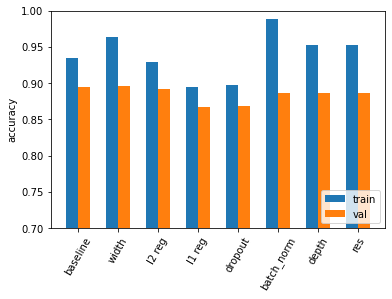

In [118]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()